In [1]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms


from utils import imshow, image_folder_custom_label

In [2]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 

])

In [5]:
imagnet_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

True Image & True Label


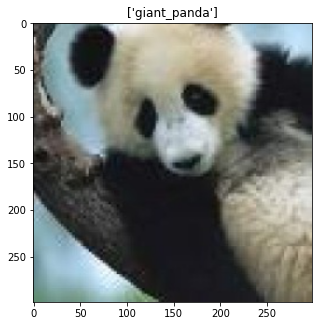

In [6]:
images, labels = iter(data_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])

In [7]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
       
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [8]:
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.resnet18(pretrained=True)
).to(device)

model = model.eval()

In [9]:
from collections import OrderedDict
from collections.abc import Iterable

def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get('_attacks').values():
            eval("atk."+func.__name__+"(*args, **kwargs)")
        return result
    return wrapper_func

class Attack(object):
    
    def __init__(self, name, model):
       

        self.attack = name
        self._attacks = OrderedDict()
        
        self.set_model(model)
        self.device = next(model.parameters()).device

        
        self.attack_mode = 'default'
        self.supported_mode = ['default']
        self.targeted = False
        self._target_map_function = None

        self.normalization_used = None
        self._normalization_applied = None
        self._set_auto_normalization_used(model)

        
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
  
        raise NotImplementedError
        
    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = str(model).split("(")[0]

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag
    
    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_auto_normalization_used(self, model):
        mean = getattr(model, 'mean', None)
        std = getattr(model, 'std', None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used['mean'] = mean
        self.normalization_used['std'] = std
        self._normalization_applied = True

    def normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return inputs*std + mean

    def get_mode(self):

        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):

        self.attack_mode = 'default'
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        print("Attack mode is changed to '%s'."%mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function):
 
        self._set_mode_targeted('targeted(custom)')
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self):

        self._set_mode_targeted('targeted(random)')
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1):

        self._set_mode_targeted('targeted(least-likely)')
        assert (kth_min > 0)
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_model_training_mode(self, model_training=False, batchnorm_training=False, dropout_training=False):

        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if 'BatchNorm' in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if 'Dropout' in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False,
             save_predictions=False, save_clean_inputs=False, save_type='float'):

        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = (pred == labels.to(self.device))
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    
                    delta = (adv_inputs - inputs.to(self.device)).view(batch_size, -1)
                    l2_distance.append(torch.norm(delta[~right_idx], p=2, dim=1))
                    l2 = torch.cat(l2_distance).mean().item()

                   
                    progress = (step+1)/total_batch*100
                    end = time.time()
                    elapsed_time = end-start

                    if verbose:
                        self._save_print(progress, rob_acc, l2, elapsed_time, end='\r')

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)
                
                save_dict = {'adv_inputs':adv_input_list_cat, 'labels':label_list_cat}

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict['preds'] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict['clean_inputs'] = input_list_cat
                    
                if self.normalization_used is not None:
                    save_dict['adv_inputs'] = self.inverse_normalize(save_dict['adv_inputs'])
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.inverse_normalize(save_dict['clean_inputs'])

                if save_type == 'int':
                    save_dict['adv_inputs'] = self.to_type(save_dict['adv_inputs'], 'int')
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.to_type(save_dict['clean_inputs'], 'int')

                save_dict['save_type'] = save_type
                torch.save(save_dict, save_path)

        
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end='\n')

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        
        if type == 'int':
            if isinstance(inputs, torch.FloatTensor) or isinstance(inputs, torch.cuda.FloatTensor):
                return (inputs*255).type(torch.uint8)
        elif type == 'float':
            if isinstance(inputs, torch.ByteTensor) or isinstance(inputs, torch.cuda.ByteTensor):
                return inputs.float()/255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print('- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t' \
              % (progress, rob_acc, l2, elapsed_time), end=end)

    @staticmethod
    def load(load_path, batch_size=128, shuffle=False, normalize=None,
             load_predictions=False, load_clean_inputs=False):
        save_dict = torch.load(load_path)
        keys = ['adv_inputs', 'labels']

        if load_predictions:
            keys.append('preds')
        if load_clean_inputs:
            keys.append('clean_inputs')

        if save_dict['save_type'] == 'int':
            save_dict['adv_inputs'] = save_dict['adv_inputs'].float()/255
            if load_clean_inputs:
                save_dict['clean_inputs'] = save_dict['clean_inputs'].float()/255
                
        if normalize is not None:
            n_channels = len(normalize['mean'])
            mean = torch.tensor(normalize['mean']).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize['std']).reshape(1, n_channels, 1, 1)
            save_dict['adv_inputs'] = (save_dict['adv_inputs'] - mean) / std
            if load_clean_inputs:
                save_dict['clean_inputs'] = (save_dict['clean_inputs'] - mean) / std

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print("Data is loaded in the following order: [%s]"%(", ".join(keys)))
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
 
        if self._target_map_function is None:
            raise ValueError('target_map_function is not initialized by set_mode_targeted.')
        target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l)*torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ['model', 'attack', 'supported_mode']

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info['attack_mode'] = self.attack_mode
        info['normalization_used'] = True if self.normalization_used is not None else False

        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)
        
        attacks = self.__dict__.get('_attacks')

        
        def get_all_values(items, stack=[]):
            if (items not in stack):
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = (list(items.keys())+list(items.values()))
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items
                
        for num, value in enumerate(get_all_values(value)):
            attacks[name+"."+str(num)] = value
            for subname, subvalue in value.__dict__.get('_attacks').items():
                attacks[name+"."+subname] = subvalue

In [10]:
from itertools import chain
from torch.nn.functional import softmax
class Pixle(Attack):

    def __init__(self, model, x_dimensions=(2, 10), y_dimensions=(2, 10),
                 pixel_mapping='random', restarts=20,
                 max_iterations=10, update_each_iteration=False):
        super().__init__("Pixle", model)

        if restarts < 0 or not isinstance(restarts, int):
            raise ValueError('restarts must be and integer >= 0 '
                             '({})'.format(restarts))

        self.update_each_iteration = update_each_iteration
        self.max_patches = max_iterations

        self.restarts = restarts
        self.pixel_mapping = pixel_mapping.lower()

        if self.pixel_mapping not in ['random', 'similarity',
                                      'similarity_random', 'distance',
                                      'distance_random']:
            raise ValueError('pixel_mapping must be one of [random, similarity,'
                             'similarity_random, distance, distance_random]'
                             ' ({})'.format(self.pixel_mapping))

        if isinstance(y_dimensions, (int, float)):
            y_dimensions = [y_dimensions, y_dimensions]

        if isinstance(x_dimensions, (int, float)):
            x_dimensions = [x_dimensions, x_dimensions]

        if not all([(isinstance(d, (int)) and d > 0)
                    or (isinstance(d, float) and 0 <= d <= 1)
                    for d in chain(y_dimensions, x_dimensions)]):
            raise ValueError('dimensions of first patch must contains integers'
                             ' or floats in [0, 1]'
                             ' ({})'.format(y_dimensions))

        self.p1_x_dimensions = x_dimensions
        self.p1_y_dimensions = y_dimensions

        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        if not self.update_each_iteration:
            return self.restart_forward(images, labels)
        else:
            return self.iterative_forward(images, labels)

    def restart_forward(self, images, labels):
        if len(images.shape) == 3:
            images = images.unsqueeze(0)

        if self.targeted:
            labels = self.get_target_label(images, labels)

        x_bounds = tuple(
            [max(1, d if isinstance(d, int) else round(images.size(3) * d))
             for d in self.p1_x_dimensions])

        y_bounds = tuple(
            [max(1, d if isinstance(d, int) else round(images.size(2) * d))
             for d in self.p1_y_dimensions])

        adv_images = []

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        bs, _, _, _ = images.shape

        for idx in range(bs):
            image, label = images[idx:idx + 1], labels[idx:idx + 1]

            best_image = image.clone()
            pert_image = image.clone()

            loss, callback = self._get_fun(image, label,
                                           target_attack=self.targeted)
            best_solution = None

            best_p = loss(solution=image, solution_as_perturbed=True)
            image_probs = [best_p]

            it = 0

            for r in range(self.restarts):
                stop = False

                for it in range(self.max_patches):

                    (x, y), (x_offset, y_offset) = \
                        self.get_patch_coordinates(image=image,
                                                   x_bounds=x_bounds,
                                                   y_bounds=y_bounds)

                    destinations = self.get_pixel_mapping(image, x, x_offset,
                                                          y, y_offset,
                                                          destination_image=
                                                          best_image)

                    solution = [x, y, x_offset, y_offset] + destinations

                    pert_image = self._perturb(source=image,
                                               destination=best_image,
                                               solution=solution)

                    p = loss(solution=pert_image,
                             solution_as_perturbed=True)

                    if p < best_p:
                        best_p = p
                        best_solution = pert_image

                    image_probs.append(best_p)

                    if callback(pert_image, None, True):
                        best_solution = pert_image
                        stop = True
                        break

                if best_solution is None:
                    best_image = pert_image
                else:
                    best_image = best_solution

                if stop:
                    break

            adv_images.append(best_image)

        adv_images = torch.cat(adv_images)

        return adv_images

    def iterative_forward(self, images, labels):
        assert len(images.shape) == 3 or \
               (len(images.shape) == 4 and images.size(0) == 1)

        if len(images.shape) == 3:
            images = images.unsqueeze(0)

        if self.targeted:
            labels = self.get_target_label(images, labels)

        x_bounds = tuple(
            [max(1, d if isinstance(d, int) else round(images.size(3) * d))
             for d in self.p1_x_dimensions])

        y_bounds = tuple(
            [max(1, d if isinstance(d, int) else round(images.size(2) * d))
             for d in self.p1_y_dimensions])

        adv_images = []

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        bs, _, _, _ = images.shape

        for idx in range(bs):
            image, label = images[idx:idx + 1], labels[idx:idx + 1]

            best_image = image.clone()

            loss, callback = self._get_fun(image, label,
                                           target_attack=self.targeted)

            best_p = loss(solution=image, solution_as_perturbed=True)
            image_probs = [best_p]

            for it in range(self.max_patches):

                (x, y), (x_offset, y_offset) = \
                    self.get_patch_coordinates(image=image,
                                               x_bounds=x_bounds,
                                               y_bounds=y_bounds)

                destinations = self.get_pixel_mapping(image, x, x_offset,
                                                      y, y_offset,
                                                      destination_image=best_image)

                solution = [x, y, x_offset, y_offset] + destinations

                pert_image = self._perturb(source=image,
                                           destination=best_image,
                                           solution=solution)

                p = loss(solution=pert_image, solution_as_perturbed=True)

                if p < best_p:
                    best_p = p
                    best_image = pert_image

                image_probs.append(best_p)

                if callback(pert_image, None, True):
                    best_image = pert_image
                    break

            adv_images.append(best_image)

        adv_images = torch.cat(adv_images)

        return adv_images

    def _get_prob(self, image):
        out = self.get_logits(image.to(self.device))
        prob = softmax(out, dim=1)
        return prob.detach().cpu().numpy()

    def loss(self, img, label, target_attack=False):

        p = self._get_prob(img)
        p = p[np.arange(len(p)), label]

        if target_attack:
            p = 1 - p

        return p.sum()

    def get_patch_coordinates(self, image, x_bounds, y_bounds):
        c, h, w = image.shape[1:]

        x, y = np.random.uniform(0, 1, 2)

        x_offset = np.random.randint(x_bounds[0],
                                     x_bounds[1] + 1)

        y_offset = np.random.randint(y_bounds[0],
                                     y_bounds[1] + 1)

        x, y = int(x * (w - 1)), int(y * (h - 1))

        if x + x_offset > w:
            x_offset = w - x

        if y + y_offset > h:
            y_offset = h - y

        return (x, y), (x_offset, y_offset)

    def get_pixel_mapping(self, source_image, x, x_offset, y, y_offset,
                          destination_image=None):
        if destination_image is None:
            destination_image = source_image

        destinations = []
        c, h, w = source_image.shape[1:]
        source_image = source_image[0]

        if self.pixel_mapping == 'random':
            for i in range(x_offset):
                for j in range(y_offset):
                    dx, dy = np.random.uniform(0, 1, 2)
                    dx, dy = int(dx * (w - 1)), int(dy * (h - 1))
                    destinations.append([dx, dy])
        else:
            for i in np.arange(y, y + y_offset):
                for j in np.arange(x, x + x_offset):
                    pixel = source_image[:, i: i + 1, j: j + 1]
                    diff = destination_image - pixel
                    diff = diff[0].abs().mean(0).view(-1)

                    if 'similarity' in self.pixel_mapping:
                        diff = 1 / (1 + diff)
                        diff[diff == 1] = 0

                    probs = torch.softmax(diff, 0).cpu().numpy()

                    indexes = np.arange(len(diff))

                    pair = None

                    linear_iter = iter(sorted(zip(indexes, probs),
                                              key=lambda pit: pit[1],
                                              reverse=True))

                    while True:
                        if 'random' in self.pixel_mapping:
                            index = np.random.choice(indexes, p=probs)
                        else:
                            index = next(linear_iter)[0]

                        _y, _x = np.unravel_index(index, (h, w))

                        if _y == i and _x == j:
                            continue

                        pair = (_x, _y)
                        break

                    destinations.append(pair)

        return destinations

    def _get_fun(self, img, label, target_attack=False):
        img = img.to(self.device)

        if isinstance(label, torch.Tensor):
            label = label.cpu().numpy()

        @torch.no_grad()
        def func(solution,
                 destination=None,
                 solution_as_perturbed=False, **kwargs):

            if not solution_as_perturbed:
                pert_image = self._perturb(source=img,
                                           destination=destination,
                                           solution=solution)
            else:
                pert_image = solution

            p = self._get_prob(pert_image)
            p = p[np.arange(len(p)), label]

            if target_attack:
                p = 1 - p

            return p.sum()

        @torch.no_grad()
        def callback(solution,
                     destination=None,
                     solution_as_perturbed=False,
                     **kwargs):

            if not solution_as_perturbed:
                pert_image = self._perturb(source=img,
                                           destination=destination,
                                           solution=solution)
            else:
                pert_image = solution

            p = self._get_prob(pert_image)[0]
            mx = np.argmax(p)

            if target_attack:
                return mx == label
            else:
                return mx != label

        return func, callback

    def _perturb(self, source, solution, destination=None):
        if destination is None:
            destination = source

        c, h, w = source.shape[1:]

        x, y, xl, yl = solution[:4]
        destinations = solution[4:]

        source_pixels = np.ix_(range(c),
                               np.arange(y, y + yl),
                               np.arange(x, x + xl))

        indexes = torch.tensor(destinations)
        destination = destination.clone().detach().to(self.device)

        s = source[0][source_pixels].view(3, -1)

        destination[0, :, indexes[:, 0], indexes[:, 1]] = s

        return destination

In [11]:
atk1 = Pixle(model, x_dimensions=(0.1, 0.2), restarts=10)

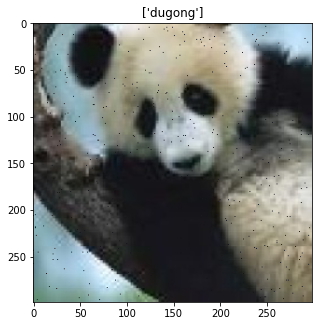

In [12]:
adv_images1 = atk1(images, labels)
labels = labels.to(device)
outputs1 = model(adv_images1)

_, pre = torch.max(outputs1.data, 1)



imshow(torchvision.utils.make_grid(adv_images1.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


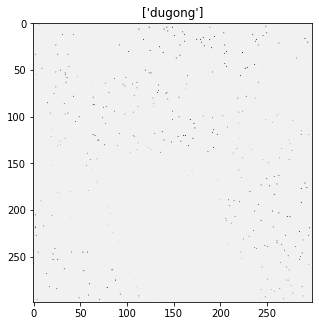

In [13]:

pert1 = adv_images1 - images


imshow(torchvision.utils.make_grid(pert1.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


In [14]:
class MIFGSM(Attack):
   

    def __init__(self, model, eps=8/255, alpha=2/255, steps=10, decay=1.0):
        super().__init__("MIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

           
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            grad = grad / torch.mean(torch.abs(grad), dim=(1,2,3), keepdim=True)
            grad = grad + momentum*self.decay
            momentum = grad

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [15]:
atk2 = MIFGSM(model, eps=8/255, steps=10, decay=1.0)

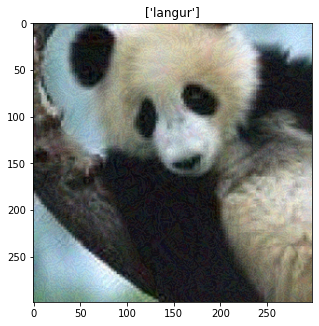

In [16]:
adv_images2 = atk2(images, labels)
labels = labels.to(device)
output2 = model(adv_images2)

_, pre = torch.max(output2.data, 1)



imshow(torchvision.utils.make_grid(adv_images2.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


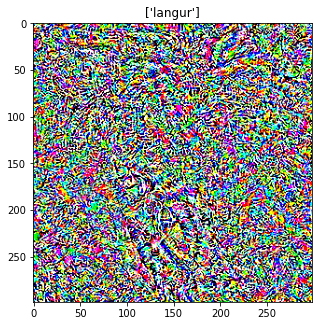

In [17]:

pert2 = adv_images2 - images


imshow(torchvision.utils.make_grid(pert2.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


In [18]:
import torch.nn.functional as F




class DIFGSM(Attack):
    

    def __init__(self, model, eps=8/255, alpha=2/255, steps=10, decay=0.0,
                 resize_rate=0.9, diversity_prob=0.5, random_start=False):
        super().__init__("DIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.resize_rate = resize_rate
        self.diversity_prob = diversity_prob
        self.random_start = random_start
        self.supported_mode = ['default', 'targeted']

    def input_diversity(self, x):
        img_size = x.shape[-1]
        img_resize = int(img_size * self.resize_rate)

        if self.resize_rate < 1:
            img_size = img_resize
            img_resize = x.shape[-1]

        rnd = torch.randint(low=img_size, high=img_resize, size=(1,), dtype=torch.int32)
        rescaled = F.interpolate(x, size=[rnd, rnd], mode='bilinear', align_corners=False)
        h_rem = img_resize - rnd
        w_rem = img_resize - rnd
        pad_top = torch.randint(low=0, high=h_rem.item(), size=(1,), dtype=torch.int32)
        pad_bottom = h_rem - pad_top
        pad_left = torch.randint(low=0, high=w_rem.item(), size=(1,), dtype=torch.int32)
        pad_right = w_rem - pad_left

        padded = F.pad(rescaled, [pad_left.item(), pad_right.item(), pad_top.item(), pad_bottom.item()], value=0)

        return padded if torch.rand(1) < self.diversity_prob else x

    def forward(self, images, labels):
       
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        momentum = torch.zeros_like(images).detach().to(self.device)

        adv_images = images.clone().detach()

        if self.random_start:
            
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(self.input_diversity(adv_images))

            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

           
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            grad = grad / torch.mean(torch.abs(grad), dim=(1,2,3), keepdim=True)
            grad = grad + momentum*self.decay
            momentum = grad

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [19]:
atk3 = DIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)

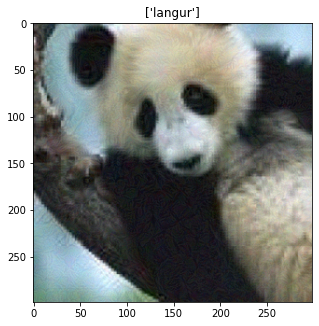

In [20]:
adv_images3 = atk3(images, labels)
labels = labels.to(device)
output3 = model(adv_images3)

_, pre = torch.max(output3.data, 1)



imshow(torchvision.utils.make_grid(adv_images3.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


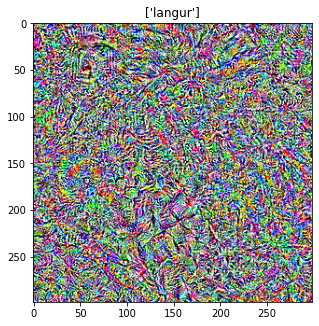

In [21]:

pert3 = adv_images3 - images


imshow(torchvision.utils.make_grid(pert3.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


In [22]:
class CW(Attack):

    def __init__(self, model, c=1, kappa=0, steps=50, lr=0.01):
        super().__init__("CW", model)
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

       
        w = self.inverse_tanh_space(images).detach()
        w.requires_grad = True

        best_adv_images = images.clone().detach()
        best_L2 = 1e10*torch.ones((len(images))).to(self.device)
        prev_cost = 1e10
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction='none')
        Flatten = nn.Flatten()

        optimizer = optim.Adam([w], lr=self.lr)

        for step in range(self.steps):
            
            adv_images = self.tanh_space(w)

            
            current_L2 = MSELoss(Flatten(adv_images),
                                 Flatten(images)).sum(dim=1)
            L2_loss = current_L2.sum()

            outputs = self.get_logits(adv_images)
            if self.targeted:
                f_loss = self.f(outputs, target_labels).sum()
            else:
                f_loss = self.f(outputs, labels).sum()

            cost = L2_loss + self.c*f_loss

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            
            _, pre = torch.max(outputs.detach(), 1)
            correct = (pre == labels).float()

            
            mask = (1-correct)*(best_L2 > current_L2.detach())
            best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

            mask = mask.view([-1]+[1]*(dim-1))
            best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

            
            if step % max(self.steps//10,1) == 0:
                if cost.item() > prev_cost:
                    return best_adv_images
                prev_cost = cost.item()

        return best_adv_images

    def tanh_space(self, x):
        return 1/2*(torch.tanh(x) + 1)

    def inverse_tanh_space(self, x):
       
        return self.atanh(x*2-1)

    def atanh(self, x):
        return 0.5*torch.log((1+x)/(1-x))

   
    def f(self, outputs, labels):
        one_hot_labels = torch.eye(len(outputs[0])).to(self.device)[labels]

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1) 
        j = torch.masked_select(outputs, one_hot_labels.bool())

        if self.targeted:
            return torch.clamp((i-j), min=-self.kappa)
        else:
            return torch.clamp((j-i), min=-self.kappa)


In [23]:
atk4 = CW(model, c=1, kappa=0, steps=50, lr=0.01)

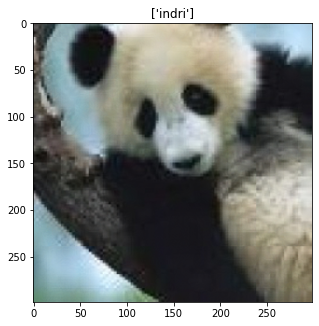

In [24]:
adv_images4 = atk4(images, labels)
labels = labels.to(device)
output4 = model(adv_images4)

_, pre = torch.max(output4.data, 1)



imshow(torchvision.utils.make_grid(adv_images4.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


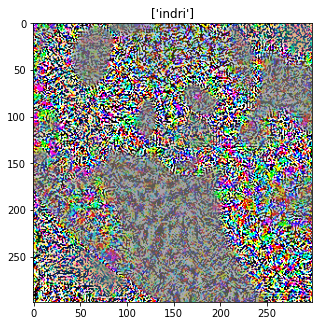

In [25]:

pert4 = adv_images4 - images


imshow(torchvision.utils.make_grid(pert4.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])

In [26]:
class Jitter(Attack):
  
    def __init__(self, model, eps=8/255, alpha=2/255, steps=10,
                 scale=10, std=0.1, random_start=True):
        super().__init__("Jitter", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.scale = scale
        self.std = std
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.MSELoss(reduction='none')

        adv_images = images.clone().detach()

        if self.random_start:
            
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            logits = self.get_logits(adv_images)

            _, pre = torch.max(logits, dim=1)
            wrong = (pre != labels)

            norm_z = torch.norm(logits, p=float('inf'), dim=1, keepdim=True)
            hat_z = nn.Softmax(dim=1)(self.scale*logits/norm_z)

            if self.std != 0:
                hat_z = hat_z + self.std*torch.randn_like(hat_z)

            
            if self.targeted:
                target_Y = F.one_hot(target_labels, num_classes=logits.shape[-1]).float()
                cost = -loss(hat_z, target_Y).mean(dim=1)
            else:
                Y = F.one_hot(labels, num_classes=logits.shape[-1]).float()
                cost = loss(hat_z, Y).mean(dim=1)

            norm_r = torch.norm((adv_images - images), p=float('inf'), dim=[1,2,3])
            nonzero_r = (norm_r != 0)
            cost[wrong*nonzero_r] /= norm_r[wrong*nonzero_r]

            cost = cost.mean()

            
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [27]:
atk5 = Jitter(model, eps=8/255, alpha=2/255, steps=10,
         scale=10, std=0.1, random_start=True)

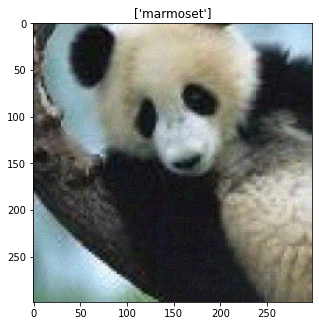

In [28]:
adv_images5 = atk5(images, labels)
labels = labels.to(device)
output5 = model(adv_images5)
_, pre = torch.max(output5.data, 1)



imshow(torchvision.utils.make_grid(adv_images5.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


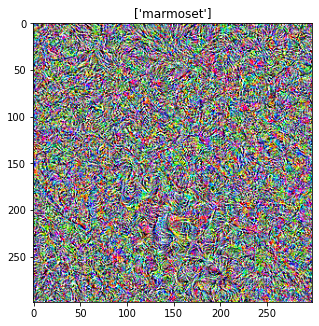

In [29]:

pert5 = adv_images5 - images


imshow(torchvision.utils.make_grid(pert5.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])
